In [2]:
import numpy as np
import pandas as pd
import xgboost
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from time import time
from sklearn.metrics import r2_score

In [3]:
data = pd.read_csv('lab1_kc_house_data.csv')

In [4]:
df_train=data.copy()
df_train.rename(columns ={'price': 'SalePrice'}, inplace =True)

In [5]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
print(len(data))
print(len(data.columns))
print(data.dtypes)

21613
21
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


In [7]:
# Check any number of columns with NaN or missing values 
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21613


In [8]:
# As id and date columns are not important to predict price so we are discarding it for finding correlation
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [9]:
# Finding Correlation of price woth other variables to see how many variables are strongly correlated with price
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [10]:
# Printing all the correlated features value with respect to price which is target variable
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


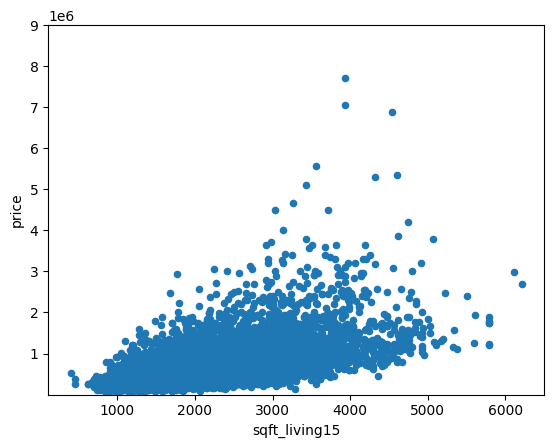

In [11]:
var = 'sqft_living15'
data = pd.concat([data['price'], data[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(3,9000000));

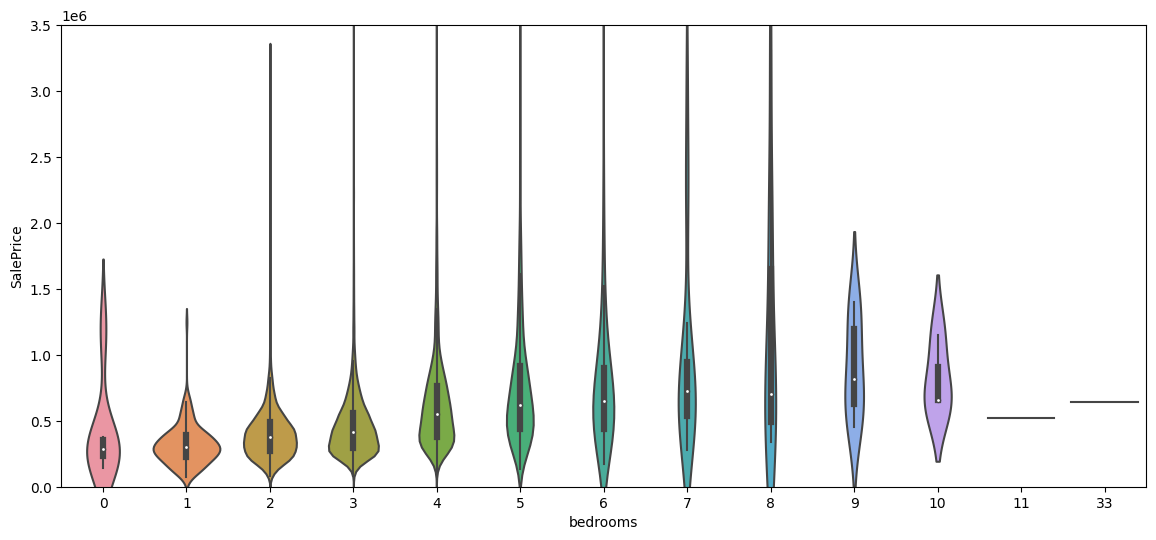

In [12]:
var = 'bedrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.violinplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

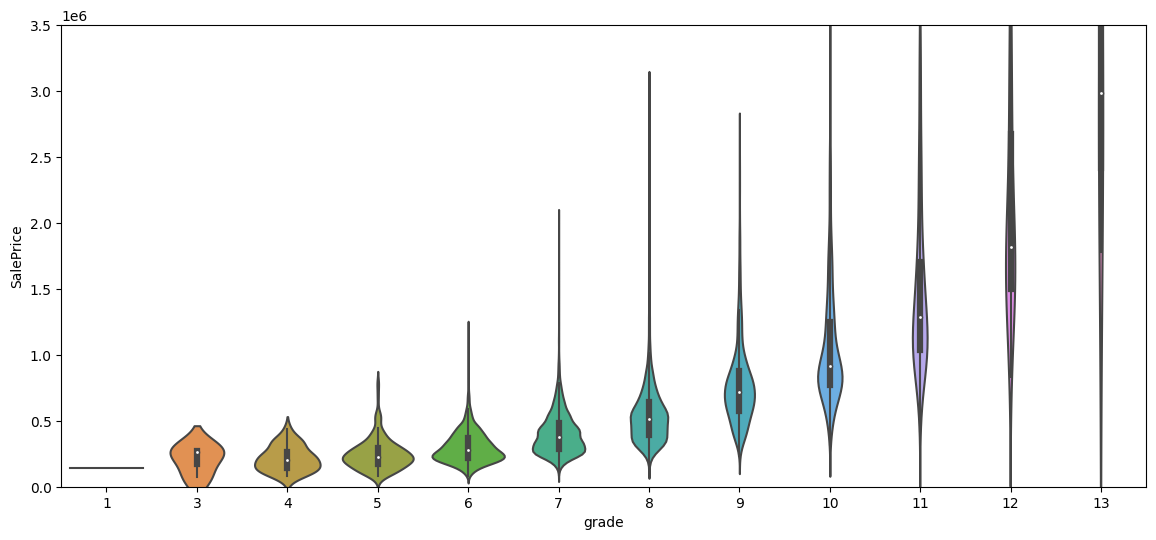

In [13]:
var = 'grade'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.violinplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

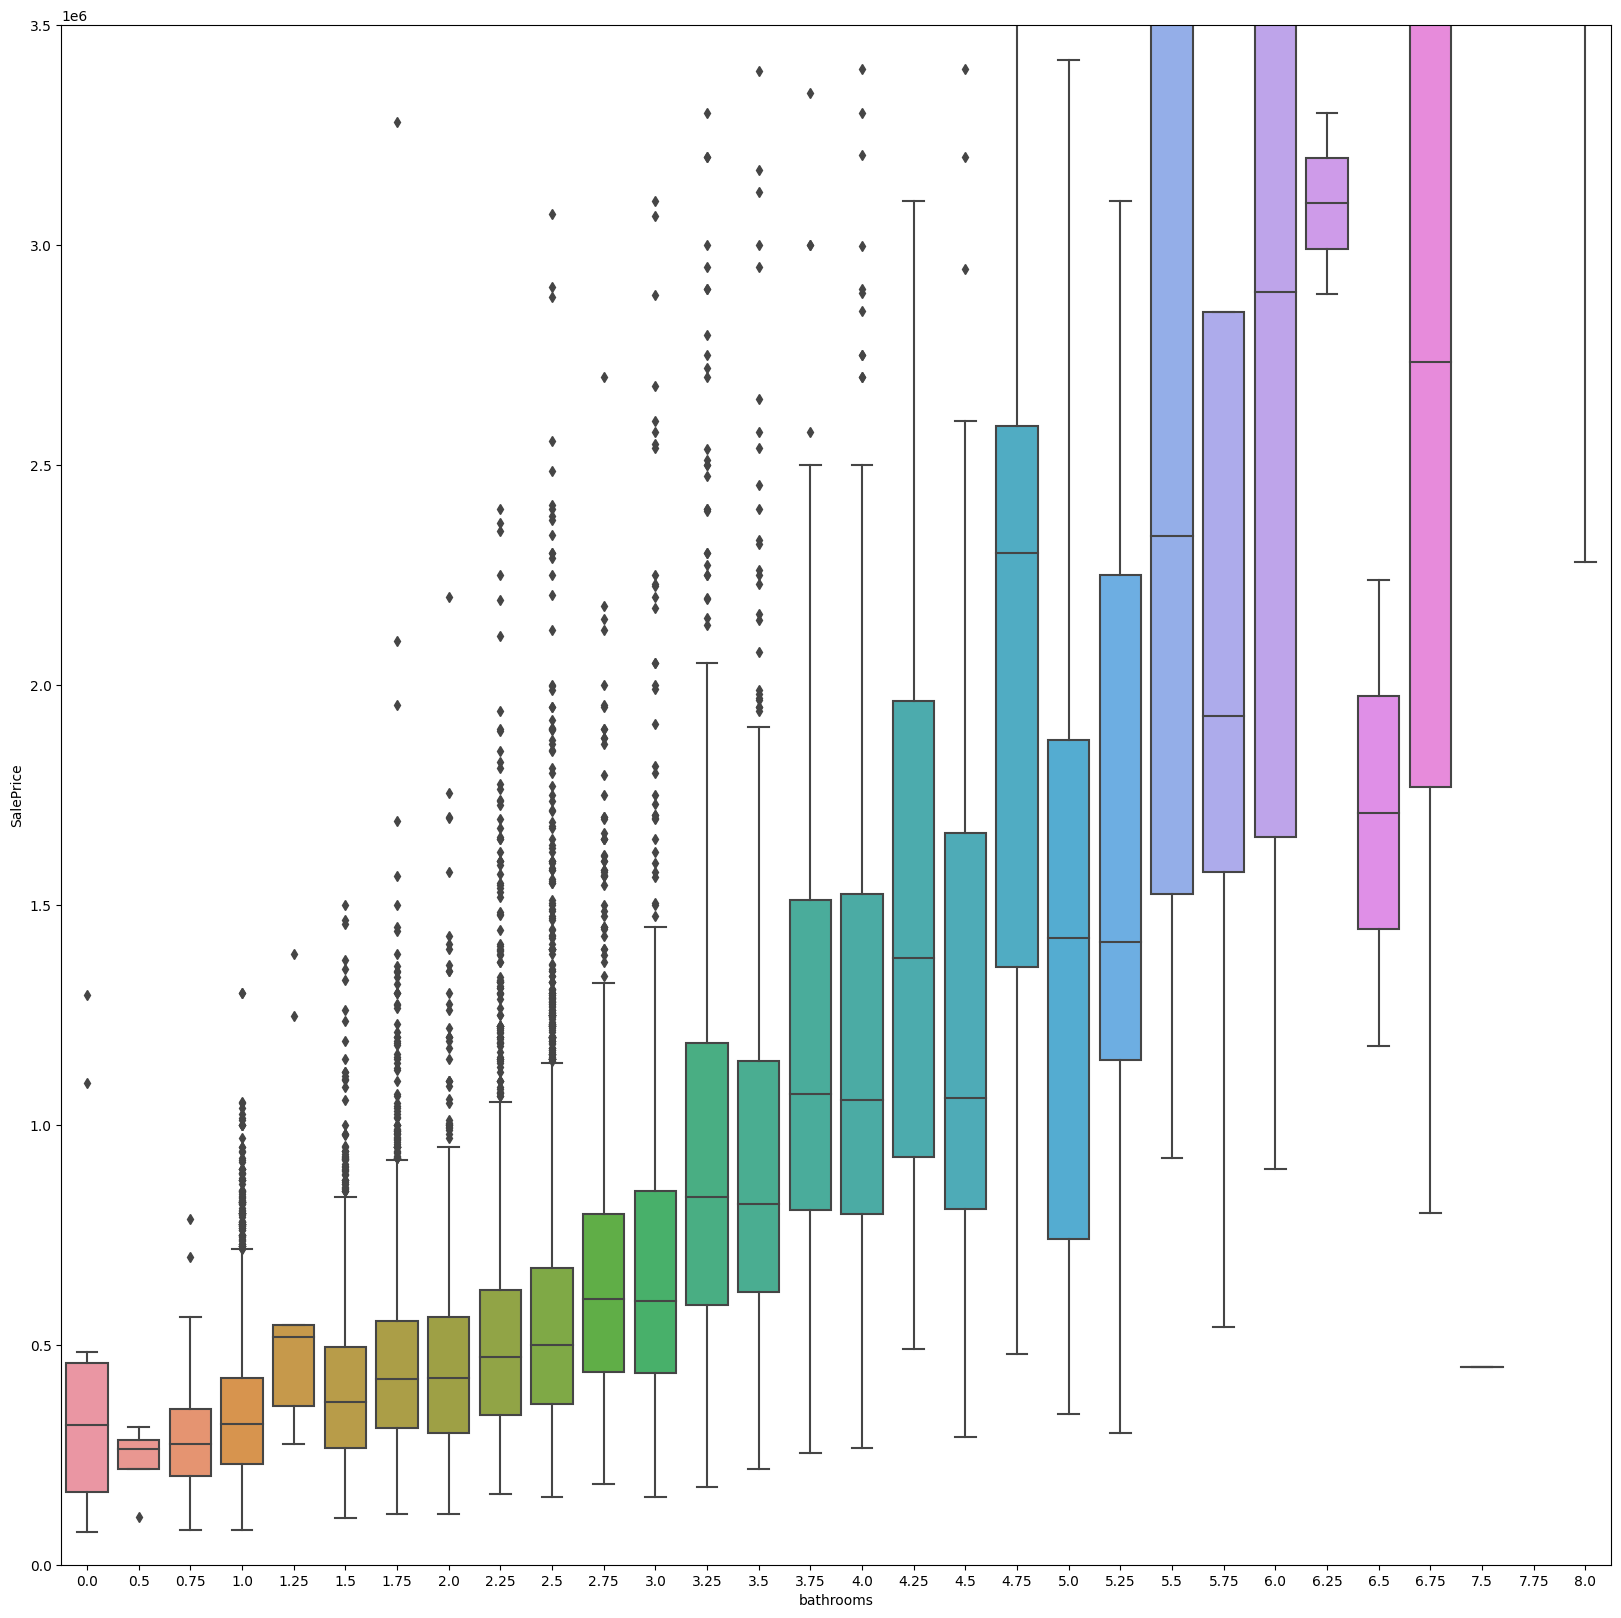

In [14]:
var = 'bathrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

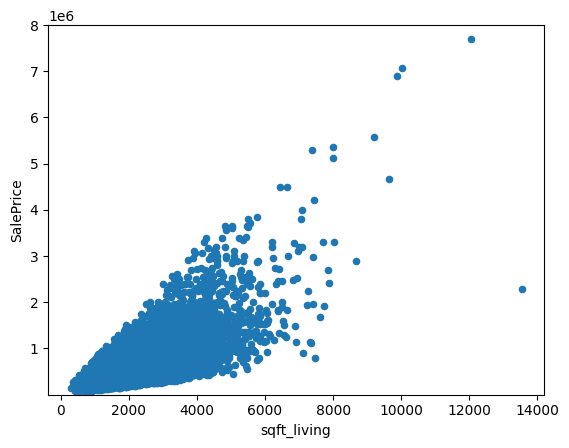

In [15]:
var = 'sqft_living'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(3,8000000));

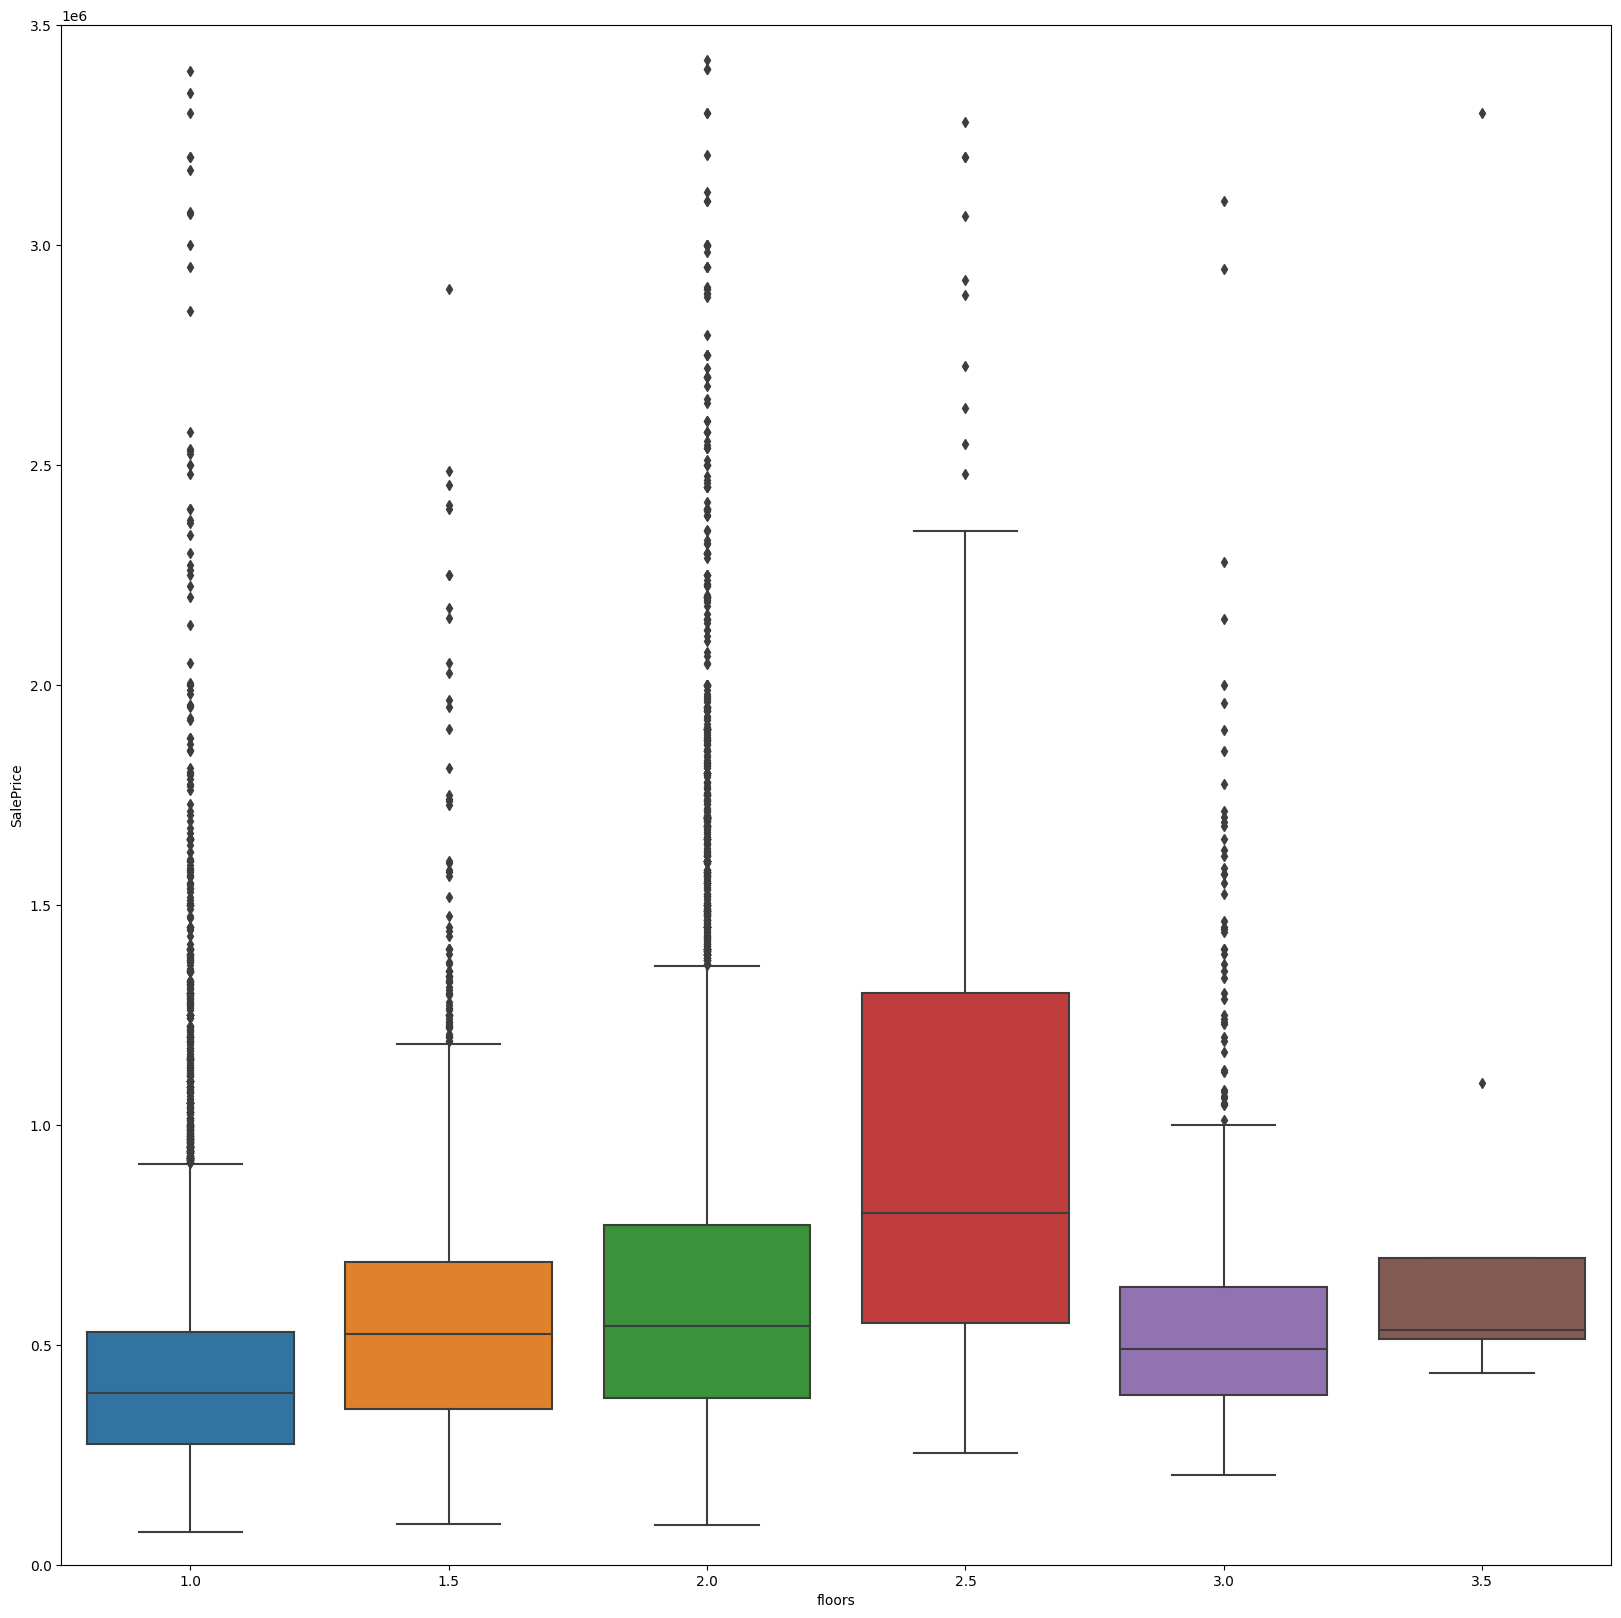

In [16]:
var = 'floors'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

In [17]:
new_data = df_train[['floors','waterfront','lat','bedrooms','sqft_basement','view','bathrooms','sqft_living15','sqft_above','grade','sqft_living']]

In [18]:
x = new_data.values
y = df_train.SalePrice.values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)

In [20]:
from sklearn.ensemble import RandomForestRegressor
rand_regr = RandomForestRegressor(n_estimators=400,random_state=0)
start = time()
rand_regr.fit(X_train, y_train)
end=time()
train_time_rand=end-start
random=rand_regr.score(X_test,y_test)
predictions = rand_regr.predict(X_test)
exp_rand = explained_variance_score(predictions,y_test)

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
start = time()
est = GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='squared_error', min_samples_split=2, learning_rate=0.01).fit(X_train, y_train)
end=time()
train_time_g=end-start
gradient=est.score(X_test,y_test)

pred = est.predict(X_test)
exp_est = explained_variance_score(pred,y_test)

In [22]:
from sklearn.tree  import DecisionTreeRegressor
decision=DecisionTreeRegressor()
start = time()
decision.fit(X_train, y_train)
end=time()
train_time_dec=end-start
decc=decision.score(X_test,y_test)
decpredict = decision.predict(X_test)
exp_dec = explained_variance_score(decpredict,y_test)

In [23]:
from sklearn.ensemble import AdaBoostRegressor
start = time()
ada=AdaBoostRegressor(n_estimators=50, learning_rate=0.2,loss='exponential').fit(X_train, y_train)
end=time()
train_time_ada=end-start
pred=ada.predict(X_test)
adab=ada.score(X_test,y_test)
predict = ada.predict(X_test)
exp_ada = explained_variance_score(predict,y_test)

In [25]:
models_cross = pd.DataFrame({
    'Model': ['Gradient Boosting','AdaBoost','Random Forest','Decision Tree'],
    'Score': [gradient,adab,random,decc],
     'Variance Score': [exp_est,exp_ada,exp_rand,exp_dec]})
    
models_cross.sort_values(by='Score', ascending=False)

,Model,Score,Variance Score
2,Random Forest,0.778359,0.746055
1,AdaBoost,0.626642,0.525628
3,Decision Tree,0.607854,0.619992
0,Gradient Boosting,0.392452,-6.690864
